<a href="https://colab.research.google.com/github/mavillot/FUNSD-Information-Extraction/blob/main/NewDataset/LayoutLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, we are going to fine-tune the LayoutLM model by Microsoft Research on the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset, which is a collection of annotated form documents. The goal of our model is to learn the annotations of a number of labels ("question", "answer", "header" and "other") on those forms, such that it can be used to annotate unseen forms in the future.

* Original LayoutLM paper: https://arxiv.org/abs/1912.13318

* Original FUNSD paper: https://arxiv.org/abs/1905.13538


## Install libraries

Currently you have to first install the `unilm` package, and then the `transformers` package (which updates the outdated `transformers` package that is included in the `unilm` package). The reason we also install the `unilm` package is because we need its preprocessing files. I've forked it, and removed some statements which introduced some issues.

In [1]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

rm: cannot remove 'unilm': No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 797, done.
remote: Total 797 (delta 0), reused 0 (delta 0), pack-reused 797
Receiving objects: 100% (797/797), 439.18 KiB | 9.15 MiB/s, done.
Resolving deltas: 100% (441/441), done.
Processing ./unilm/layoutlm
     |████████████████████████████████| 645kB 7.3MB/s 
     |████████████████████████████████| 204kB 48.0MB/s 
     |████████████████████████████████| 5.5MB 49.9MB/s 
     |████████████████████████████████| 5.6MB 40.8MB/s 
     |████████████████████████████████| 1.2MB 46.2MB/s 
     |████████████████████████████████| 901kB 45.9MB/s 
  Created wheel for layoutlm: filename=layoutlm-0.0-cp37-none-any.whl size=11488 sha256=395a8666a4f55eca593265312098ab45dc19c200c18d341a6e6e07004ee0ad3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-9n918p07/wheels/e8/9a/90/87de19930fb582e6176ea7912010f101efa37def32b8ced268
  Created wheel for seqeval: filename=seqeval-0.0.12-cp37-none-any.whl

In [2]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 78306, done.
remote: Counting objects: 100% (1344/1344), done.
remote: Compressing objects: 100% (651/651), done.
remote: Total 78306 (delta 826), reused 1043 (delta 637), pack-reused 76962
Receiving objects: 100% (78306/78306), 61.28 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (55772/55772), done.
Processing ./transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 8.8MB/s 
     |████████████████████████████████| 645kB 48.6MB/s 
  Created wheel for transformers: filename=transformers-4.9.0.dev0-cp37-none-any.whl size=2582320 sha256=9d545c47093efdc016e5d52a4f4fda08a9a5acce07aab860c0069dc35a83b751
  Stored in directory: /tmp/pip-ephem-wheel-cache-j2yend29/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully buil

## Getting the data

Here we download the data of the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/) from the web. This results in a directory called "data" being created, which has 2 subdirectories, one for training and one for testing. Each of those has 2 subdirectories in turn, one containing the images as png files and one containing the annotations in json format.

In [3]:
! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX

--2021-07-14 08:05:27--  https://guillaumejaume.github.io/FUNSD/dataset.zip
Resolving guillaumejaume.github.io (guillaumejaume.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to guillaumejaume.github.io (guillaumejaume.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16838830 (16M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  16.06M  64.6MB/s    in 0.2s    

2021-07-14 08:05:28 (64.6 MB/s) - ‘dataset.zip’ saved [16838830/16838830]

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/training_data/
  inflating: dataset/training_data/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset/
   creating: __MACOSX/dataset/training_data/
  inflating: __MACOSX/dataset/training_data/._.DS_Store  
   creating: dataset/training_data/images/
  inflating: dataset/training_data/images/92091873.png  
   creating: __MACOSX/dataset/training_data/image

Let's take a look at a training example. For this, we are going to use PIL (Python Image Library).

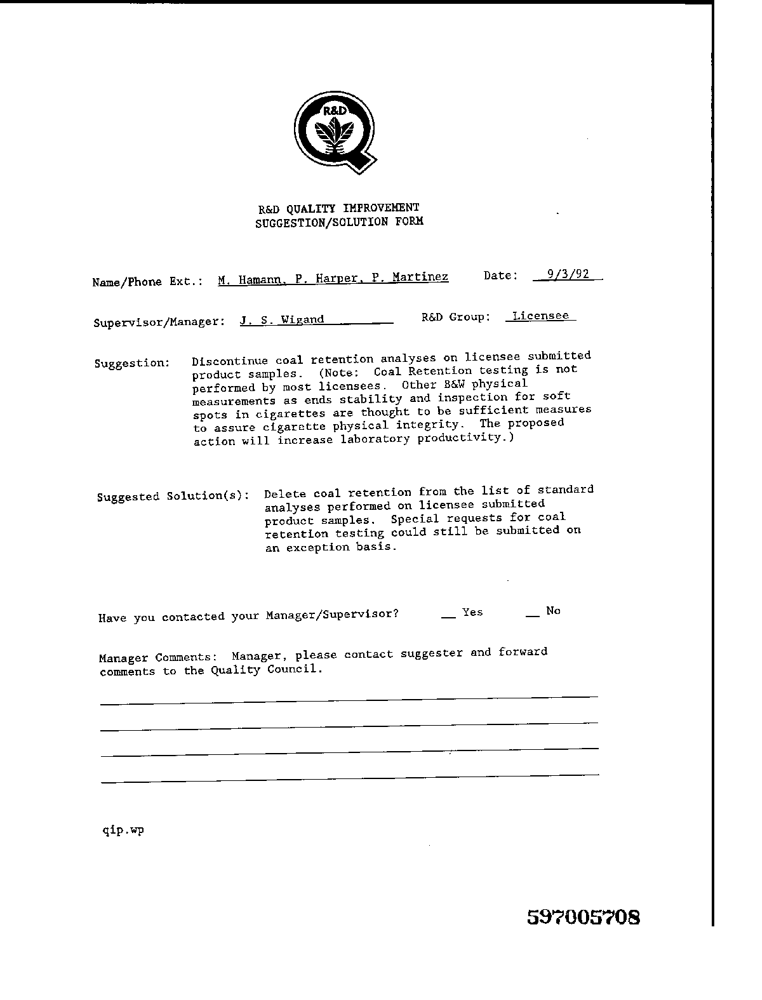

In [4]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/data/training_data/images/0000971160.png")
image = image.convert("RGB")
image

Now let's plot its corresponding annotations. Basically, if you type `data['form']`, you get a list of all general annotations. Each general annotation has a label, a bounding box, and one or more words, which in also have their own bounding box. The bounding boxes are in [xleft, ytop, xright, ybottom] format.
 

The PIL library has a handy ImageDraw module, which -you guessed it- allows to draw things (such as rectangles) on an image:

## Preprocessing the data

Next, we need to turn the document images into individual tokens and corresponding labels (BIOES format, see further). We do this both for the training and test datasets. Make sure to run this from the `/content` directory:

In [5]:
! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

! python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 510

2021-07-14 08:05:30.663506: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Downloading: 100% 170/170 [00:00<00:00, 170kB/s]
Downloading: 100% 606/606 [00:00<00:00, 640kB/s]
Downloading: 100% 232k/232k [00:00<00:00, 1.80MB/s]
Downloading: 100% 466k/466k [00:00<00:00, 2.78MB/s]
Downloading: 100% 112/112 [00:00<00:00, 114kB/s]
2021-07-14 08:05:40.915552: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Next, we create a labels.txt file that contains the unique labels of the FUNSD dataset:

In [6]:
! cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

## Define a PyTorch dataset

First, we create a list containing the unique labels based on `data/labels.txt` (run this from the content directory):

In [7]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

We can see that the dataset uses the so-called BIOES annotation scheme to annotate the tokens. This means that a given token can be either at the beginning (B), inside (I), outside (O), at the end (E) or start (S) of a given entity. Entities include ANSWER, QUESTION, HEADER and OTHER: 

In [8]:
print(labels)

['B-ANSWER', 'B-HEADER', 'B-QUESTION', 'E-ANSWER', 'E-HEADER', 'E-QUESTION', 'I-ANSWER', 'I-HEADER', 'I-QUESTION', 'O', 'S-ANSWER', 'S-HEADER', 'S-QUESTION']


Next, we can create a PyTorch dataset and corresponding dataloader (both for training and evaluation):

In [9]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)

In [10]:
len(train_dataloader)

75

In [11]:
len(eval_dataloader)

26

In [12]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

"[CLS] name address city novato state telephone ca defendant plaintiff ( x ) ( ) x ) 92433599 1 94948 ( preliminary fact sheet new filing - asbestos litigation ( see general order no. 29 ) ( in re : complex litigation ) 1. name, address and telephone number of law firm representing claimant : brayton, gisvold. & harley 999 grant avenue, p. o. box 2109 zip code ( 415 ) 898 - 1555 2. names of first named plaintiff and first named defendant on the caption of the complaint : charles woodward abex corporation, et al. 3. date of claimant's birth : june 19, 1921 4. case involves ( check appropriate boxes ) : ( a ) injury ( b ) wrongful death ( c ) consortium 5. specify the nature or type of asbestos - related injury alleged by the claimant. ( e. q., asbestosis ; lung cancer - adenocarcinoma lung cancer - mesothelioma ; pleural thickening ; fibrosis ; etc. ) mesothelioma and other asbestos - related lung disease k : \\ clients \\ 5002 \\ factshit. com [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

## Define and fine-tune the model

As this is a sequence labeling task, we are going to load `LayoutLMForTokenClassification` (the base sized model) from the hub. We are going to fine-tune it on a downstream task, namely FUNSD.

In [13]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

Now we can start training:

In [14]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

Training:   1%|▏         | 1/75 [00:00<00:25,  2.95it/s]

Loss after 0 steps: 2.5829927921295166


Training:  35%|███▍      | 26/75 [00:05<00:11,  4.45it/s]

Loss after 100 steps: 0.6705586314201355


Training:  68%|██████▊   | 51/75 [00:11<00:05,  4.30it/s]

Loss after 200 steps: 0.6387451887130737


Training:   1%|▏         | 1/75 [00:00<00:17,  4.29it/s]

Loss after 300 steps: 0.18334434926509857


Training: 100%|██████████| 75/75 [00:17<00:00,  4.19it/s]


## Evaluation

Now let's evaluate on the test set:

In [ ]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 26/26 [00:02<00:00, 12.05it/s]


{'loss': 0.9691252966339772, 'precision': 0.7239292364990689, 'recall': 0.7778889444722361, 'f1': 0.7499397154569568}


## Inference

Now comes the fun part! We can now use the fine-tuned model and test it on unseen data.

Note that LayoutLM relies on an external OCR engine (it's not end-to-end -> that's probably something for the future). The test data itself also contains the annotated bounding boxes, but let's run an OCR engine ourselves.

So let's load in a image of the test set, run our own OCR on it to get the bounding boxes, then run LayoutLM on the individual tokens and visualize the result!

Sources:
* https://www.kaggle.com/jpmiller/layoutlm-starter
* https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0

In [15]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,970 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [16]:
!unzip Facturas.zip

Archive:  Facturas.zip
  inflating: Facturas/01.jpg         
  inflating: Facturas/01.xml         
  inflating: Facturas/02.jpg         
  inflating: Facturas/02.xml         
  inflating: Facturas/03.jpg         
  inflating: Facturas/03.xml         
  inflating: Facturas/04.jpg         
  inflating: Facturas/04.xml         
  inflating: Facturas/05.jpg         
  inflating: Facturas/05.xml         
  inflating: Facturas/06.jpg         
  inflating: Facturas/06.xml         
  inflating: Facturas/07.jpg         
  inflating: Facturas/07.xml         
  inflating: Facturas/08.jpg         
  inflating: Facturas/08.xml         
  inflating: Facturas/09.jpg         
  inflating: Facturas/09.xml         
  inflating: Facturas/10.jpg         
  inflating: Facturas/10.xml         
  inflating: Facturas/11.jpg         
  inflating: Facturas/11.xml         
  inflating: Facturas/12.jpg         
  inflating: Facturas/12.xml         
  inflating: Facturas/13.jpg         
  inflating: Facturas/13.xm

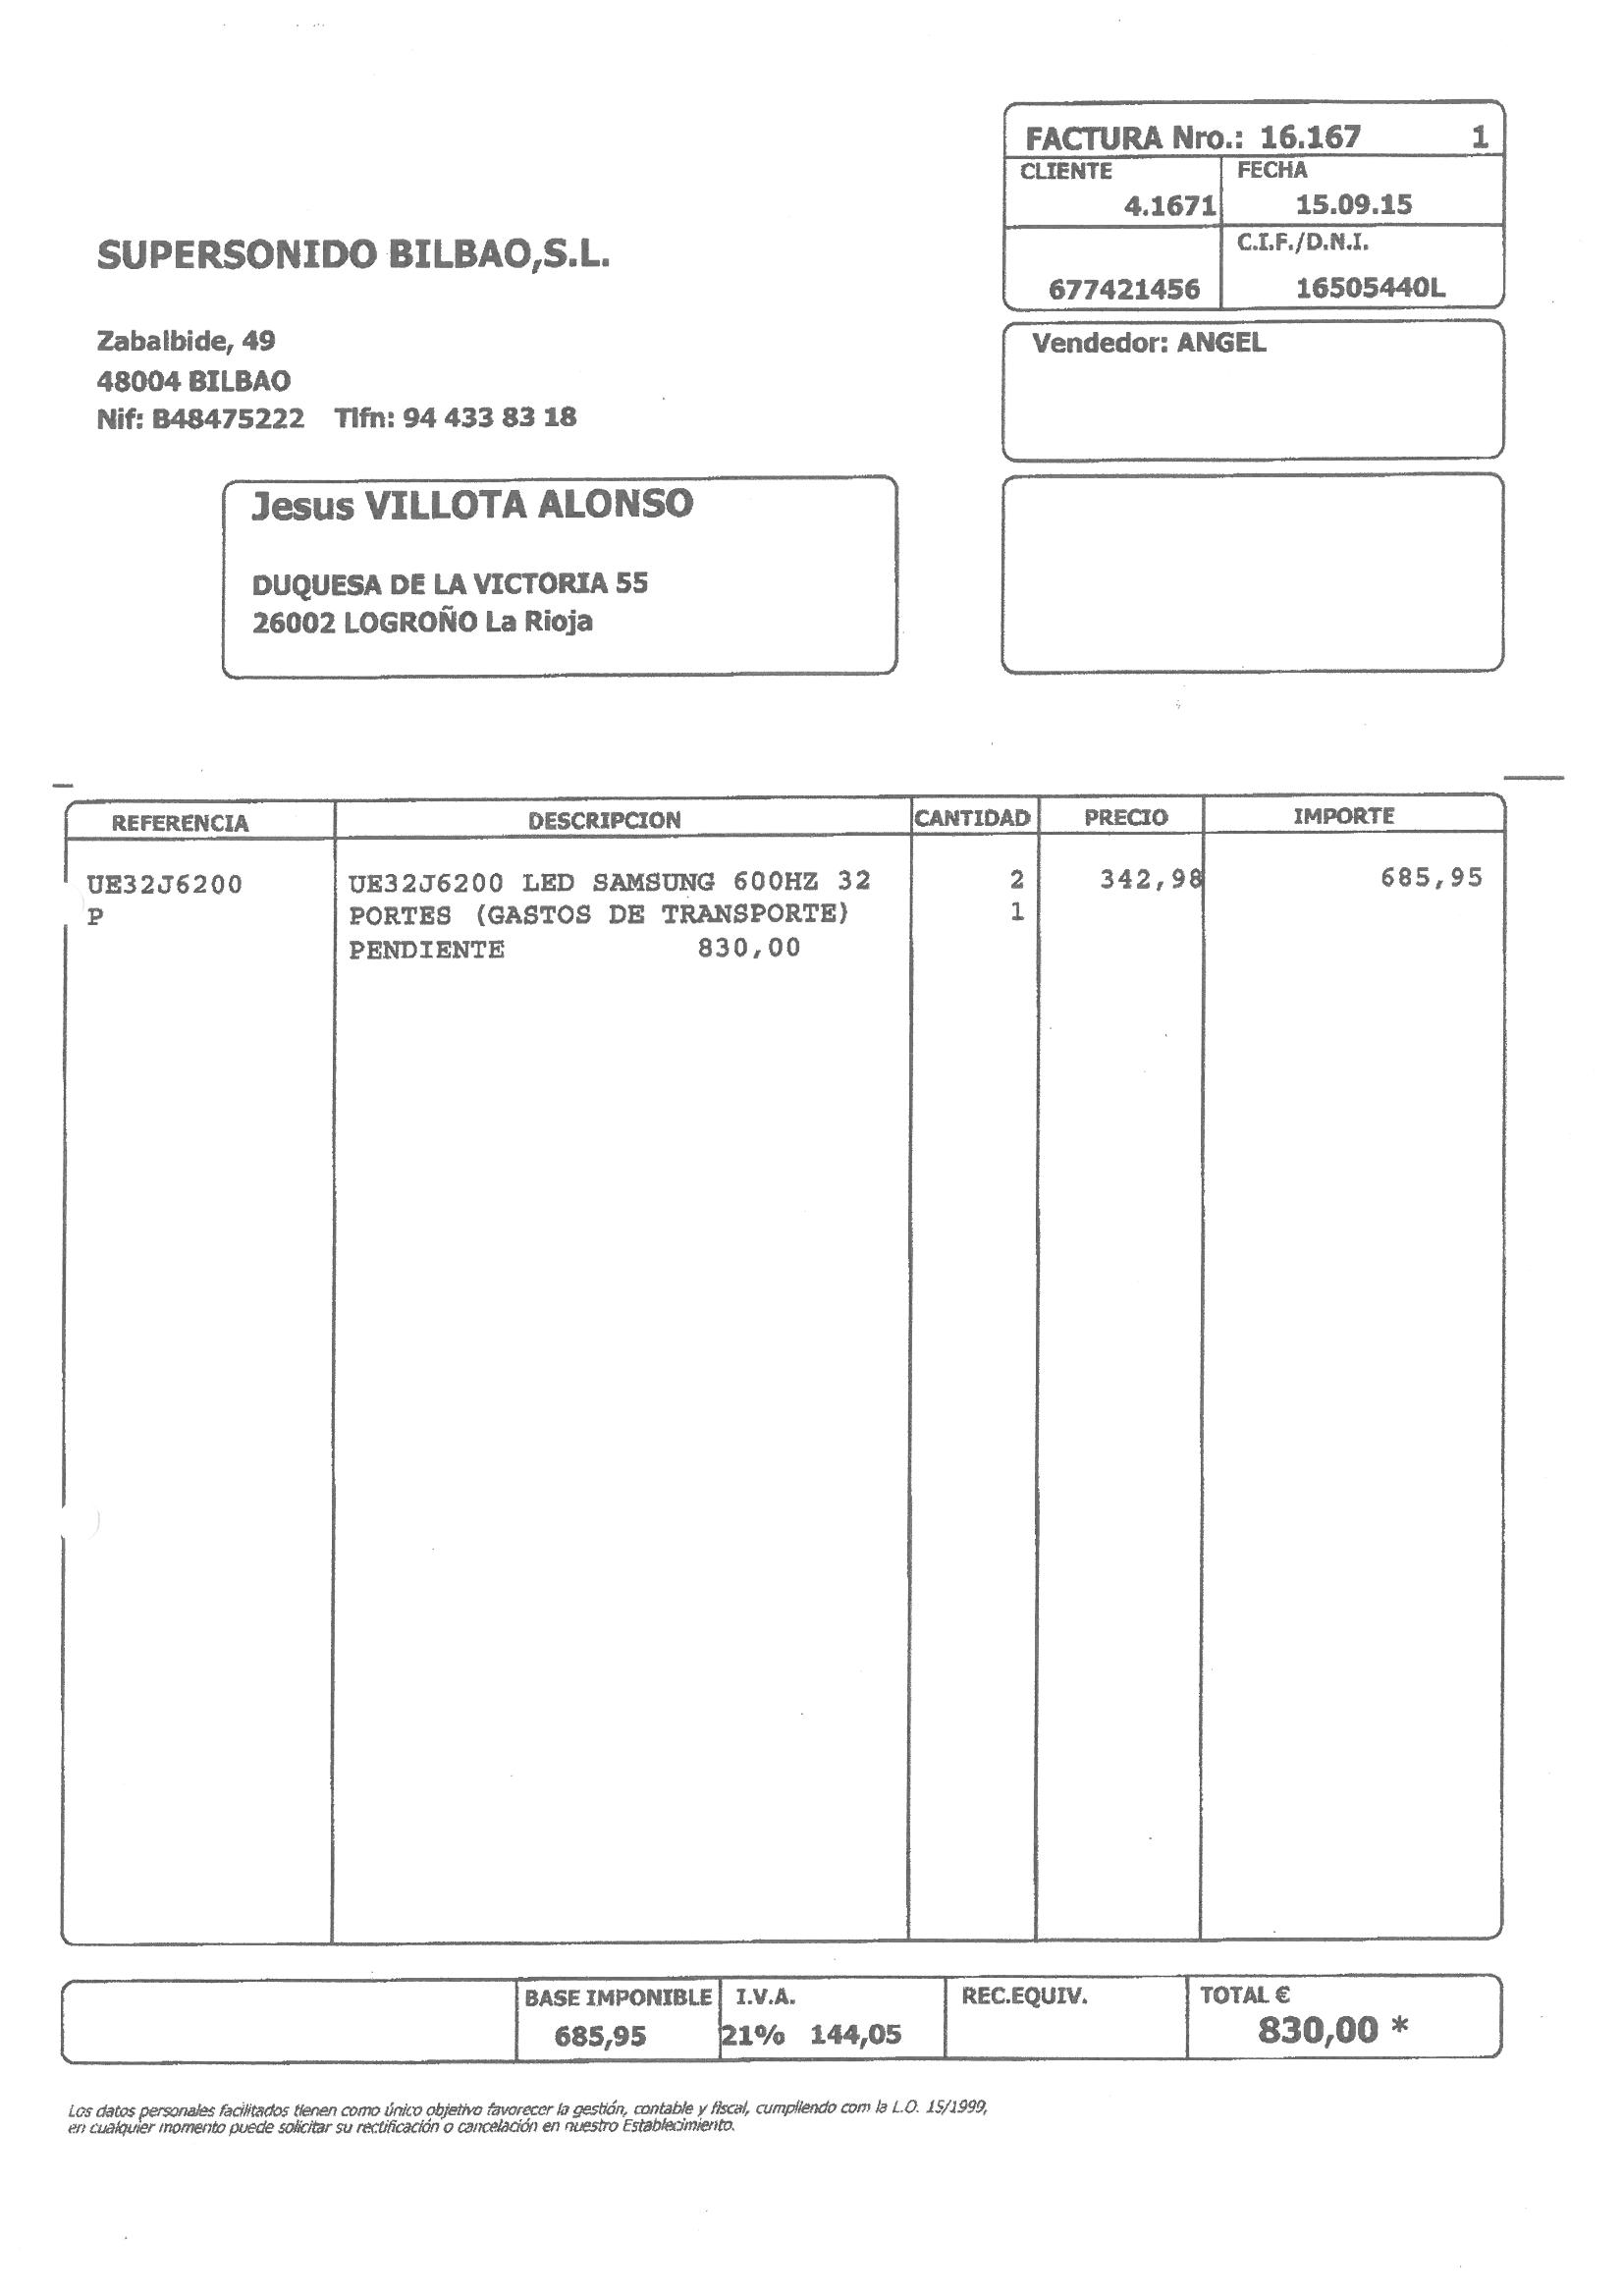

In [17]:
import pytesseract

#image = Image.open('/content/form_example.jpg')
image = Image.open("/content/Facturas/01.jpg")
image = image.convert("RGB")
image

Here we run Tesseract (an OCR engine built by Google) on the image:

In [18]:
import numpy as np

width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \
            
ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)
ocr_df[:20]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,left_scaled,width_scaled,top_scaled,height_scaled,right_scaled,bottom_scaled
0,5,1,2,1,1,1,1046,128,139,25,92,FACTURA,633,84,55,11,717,65
1,5,1,2,1,1,2,1195,128,70,24,91,Nro.:,723,42,55,10,765,65
2,5,1,2,1,1,3,1285,127,101,25,90,16.167,777,61,54,11,838,65
3,5,1,2,1,2,1,1040,165,92,18,92,CLIENTE,629,56,71,8,685,78
4,5,1,2,1,2,2,1261,164,71,17,96,FECHA,763,43,70,7,806,77
5,5,1,2,1,3,1,1145,198,94,22,95,4.1671,693,57,85,9,750,94
6,5,1,2,1,3,2,1321,197,117,21,96,15.09.15,799,71,84,9,870,93
7,5,1,4,1,1,1,100,243,284,32,89,SUPERSONIDO,60,172,104,14,232,118
8,5,1,4,1,1,2,398,242,222,37,53,"BILBAO,S.L.",241,134,104,16,375,119
9,5,1,4,1,1,3,1261,236,132,23,13,CLF/D.NI.,763,80,101,10,843,111


In [19]:
len(ocr_df)

112

Here we create a list of words, actual bounding boxes, and normalized boxes.

In [20]:
words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
boxes

[[632, 54, 716, 65],
 [722, 54, 765, 65],
 [777, 54, 838, 65],
 [629, 70, 684, 78],
 [762, 70, 805, 77],
 [692, 84, 749, 94],
 [799, 84, 869, 93],
 [60, 103, 232, 117],
 [240, 103, 375, 119],
 [762, 100, 842, 110],
 [646, 121, 739, 130],
 [799, 120, 891, 130],
 [59, 143, 143, 154],
 [149, 143, 169, 152],
 [636, 144, 719, 153],
 [725, 144, 780, 153],
 [59, 161, 111, 171],
 [116, 161, 179, 170],
 [60, 177, 88, 186],
 [94, 177, 187, 187],
 [0, 0, 1000, 1000],
 [206, 177, 242, 186],
 [248, 177, 269, 186],
 [274, 177, 304, 186],
 [309, 177, 329, 186],
 [335, 176, 355, 185],
 [154, 213, 217, 226],
 [225, 213, 324, 226],
 [331, 212, 427, 225],
 [156, 250, 235, 261],
 [241, 250, 252, 258],
 [253, 249, 287, 258],
 [291, 248, 374, 258],
 [379, 248, 399, 258],
 [156, 266, 206, 275],
 [212, 263, 281, 275],
 [282, 266, 318, 275],
 [323, 265, 364, 276],
 [326, 353, 419, 361],
 [562, 347, 639, 362],
 [640, 347, 740, 362],
 [742, 346, 926, 362],
 [926, 337, 963, 340],
 [623, 54, 917, 844],
 [851, 377,

This should become the future API of LayoutLMTokenizer (`prepare_for_model()`): 

In [23]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      # assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [24]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [25]:
tokenizer.decode(input_ids)

'[CLS] factura nro. : 16. 167 cliente fecha 4. 1671 15. 09. 15 supersonido bilbao, s. l. clf / d. ni. 677421456 16505440l zabalbide, 49 vendedor : angel 48004 bilbao nif : b48475222 = tifn : 94 433 83 18 jesus villota alonso duquesa de la victoria 55 26002 logrono la rioja descripcion [ curiow | — pascro [ wrote ) t | base imponible | i. v. a. ( peete ive sanos | | ™ss0, 00 + | € 685, 95 21 % 144, 05 ( peete ive sanos | | ™ss0, 00 + | * les datos personales faciti lads henan como niko objetivo fevorscer bo past, contable y fiscal, cumpliendo com ie 1. 0. 15 / 1999, en cuakner momerito * cncue concer gu rectifcacion o cancelacien en nuestro establecimierito. ue3236200 led samsung 600hz 32 portes ( gastos de transporte ) pendiente 830, 00 ue3236200 pp [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

Now let's perform a forward pass!

In [26]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
input_ids.shape

torch.Size([1, 512])

In [29]:
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
attention_mask.shape

torch.Size([1, 512])

In [30]:
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
token_type_ids.shape

torch.Size([1, 512])

In [31]:
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
bbox.shape

torch.Size([1, 512, 4])

In [32]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
outputs

TokenClassifierOutput([('logits',
                        tensor([[[-0.5672,  0.1451, -0.0425,  ..., -0.0356,  0.1003, -1.5074],
                                 [-1.3402,  0.8026,  0.8886,  ...,  0.0429,  0.5484,  1.3387],
                                 [-1.6965, -0.0464, -0.6395,  ..., -1.1760, -0.4086, -0.0428],
                                 ...,
                                 [-0.7288, -1.9416, -0.8376,  ...,  0.4296, -1.5964, -1.3777],
                                 [-0.2940, -1.9846, -0.7572,  ...,  1.0332, -1.3815, -1.2547],
                                 [-0.7200, -1.8495, -1.0367,  ...,  2.1529, -0.6755,  0.2257]]],
                               device='cuda:0', grad_fn=<AddBackward0>))])

In [34]:
outputs.logits.shape

torch.Size([1, 512, 13])

In [35]:
outputs.logits.argmax(-1)

tensor([[ 7, 12,  9,  4, 12, 12, 12, 10, 10, 10, 12, 12, 12, 12, 10, 10, 10, 10,
         10, 10, 10, 10, 10,  1,  9,  9,  9, 11,  9,  3,  9,  9, 10, 12, 12, 12,
         12,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  0,  9,  9,  9,  9,  9,
          2,  8,  5,  5, 10, 10,  9,  9,  3,  2,  5,  9,  9,  9,  9,  9,  9,  9,
          2,  5,  5,  5,  0,  6,  6,  6,  3,  0,  6,  6,  6,  3,  0,  6,  6,  6,
          6,  6,  3,  0,  6,  6,  6,  6,  6,  6,  6,  6,  3,  3,  9,  5,  6,  6,
          3,  3,  6,  3,  3,  3,  3,  9,  9,  9,  9,  9,  2,  5,  9,  5,  9,  8,
          8,  5,  3,  5,  5,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
          9, 10,  9, 10, 10, 10,  6,  3, 10,  3, 10, 10, 10,  9,  9,  9,  9,  9,
          9,  9,  9,  9, 10,  9, 10, 10,  9,  9,  9, 10,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,

Of course, LayoutLM outputs labels at the token level, but we are interested in the predicted labels at the word level. So we should actually only incorporate the predicted labels of tokens that are the first token of a given word: 

In [36]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)

# for id, prediction in zip(input_ids.squeeze().tolist(), predictions):
#   if id != 0:
#     print(tokenizer.decode([id]), label_map[prediction])
print(word_level_predictions)

[12, 4, 12, 12, 10, 10, 10, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 1, 9, 11, 9, 3, 9, 9, 10, 12, 12, 12, 9, 10, 10, 10, 0, 9, 9, 2, 5, 10, 10, 3, 2, 9, 9, 9, 2, 5, 0, 6, 6, 3, 0, 6, 3, 0, 6, 6, 6, 3, 0, 6, 6, 6, 3, 6, 6, 6, 3, 3, 9, 9, 9, 9, 9, 2, 5, 9, 8, 8, 5, 3, 5, 5, 9, 9, 9, 9, 9, 10, 10, 10, 9, 10, 9, 10, 10, 6, 3, 10, 3, 10, 10, 10, 9, 9, 9, 9, 9, 9, 10, 10, 9, 9, 9, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 0, 3, 3, 3, 10, 9]


In [37]:
print(len(word_level_predictions))

173


In [38]:
print(len(final_boxes))

173


Let's visualize the result!

In [39]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image
image.save('layoutlm.png')

Compare this to the ground truth:

Note that we only print the labels for the general bounding boxes, for readability. Each general bounding box consists of one or more bounding boxes, which comprise the individual words:

In [40]:
import numpy as np
import os,shutil,json
import xml.etree.ElementTree as ET
from pathlib import Path

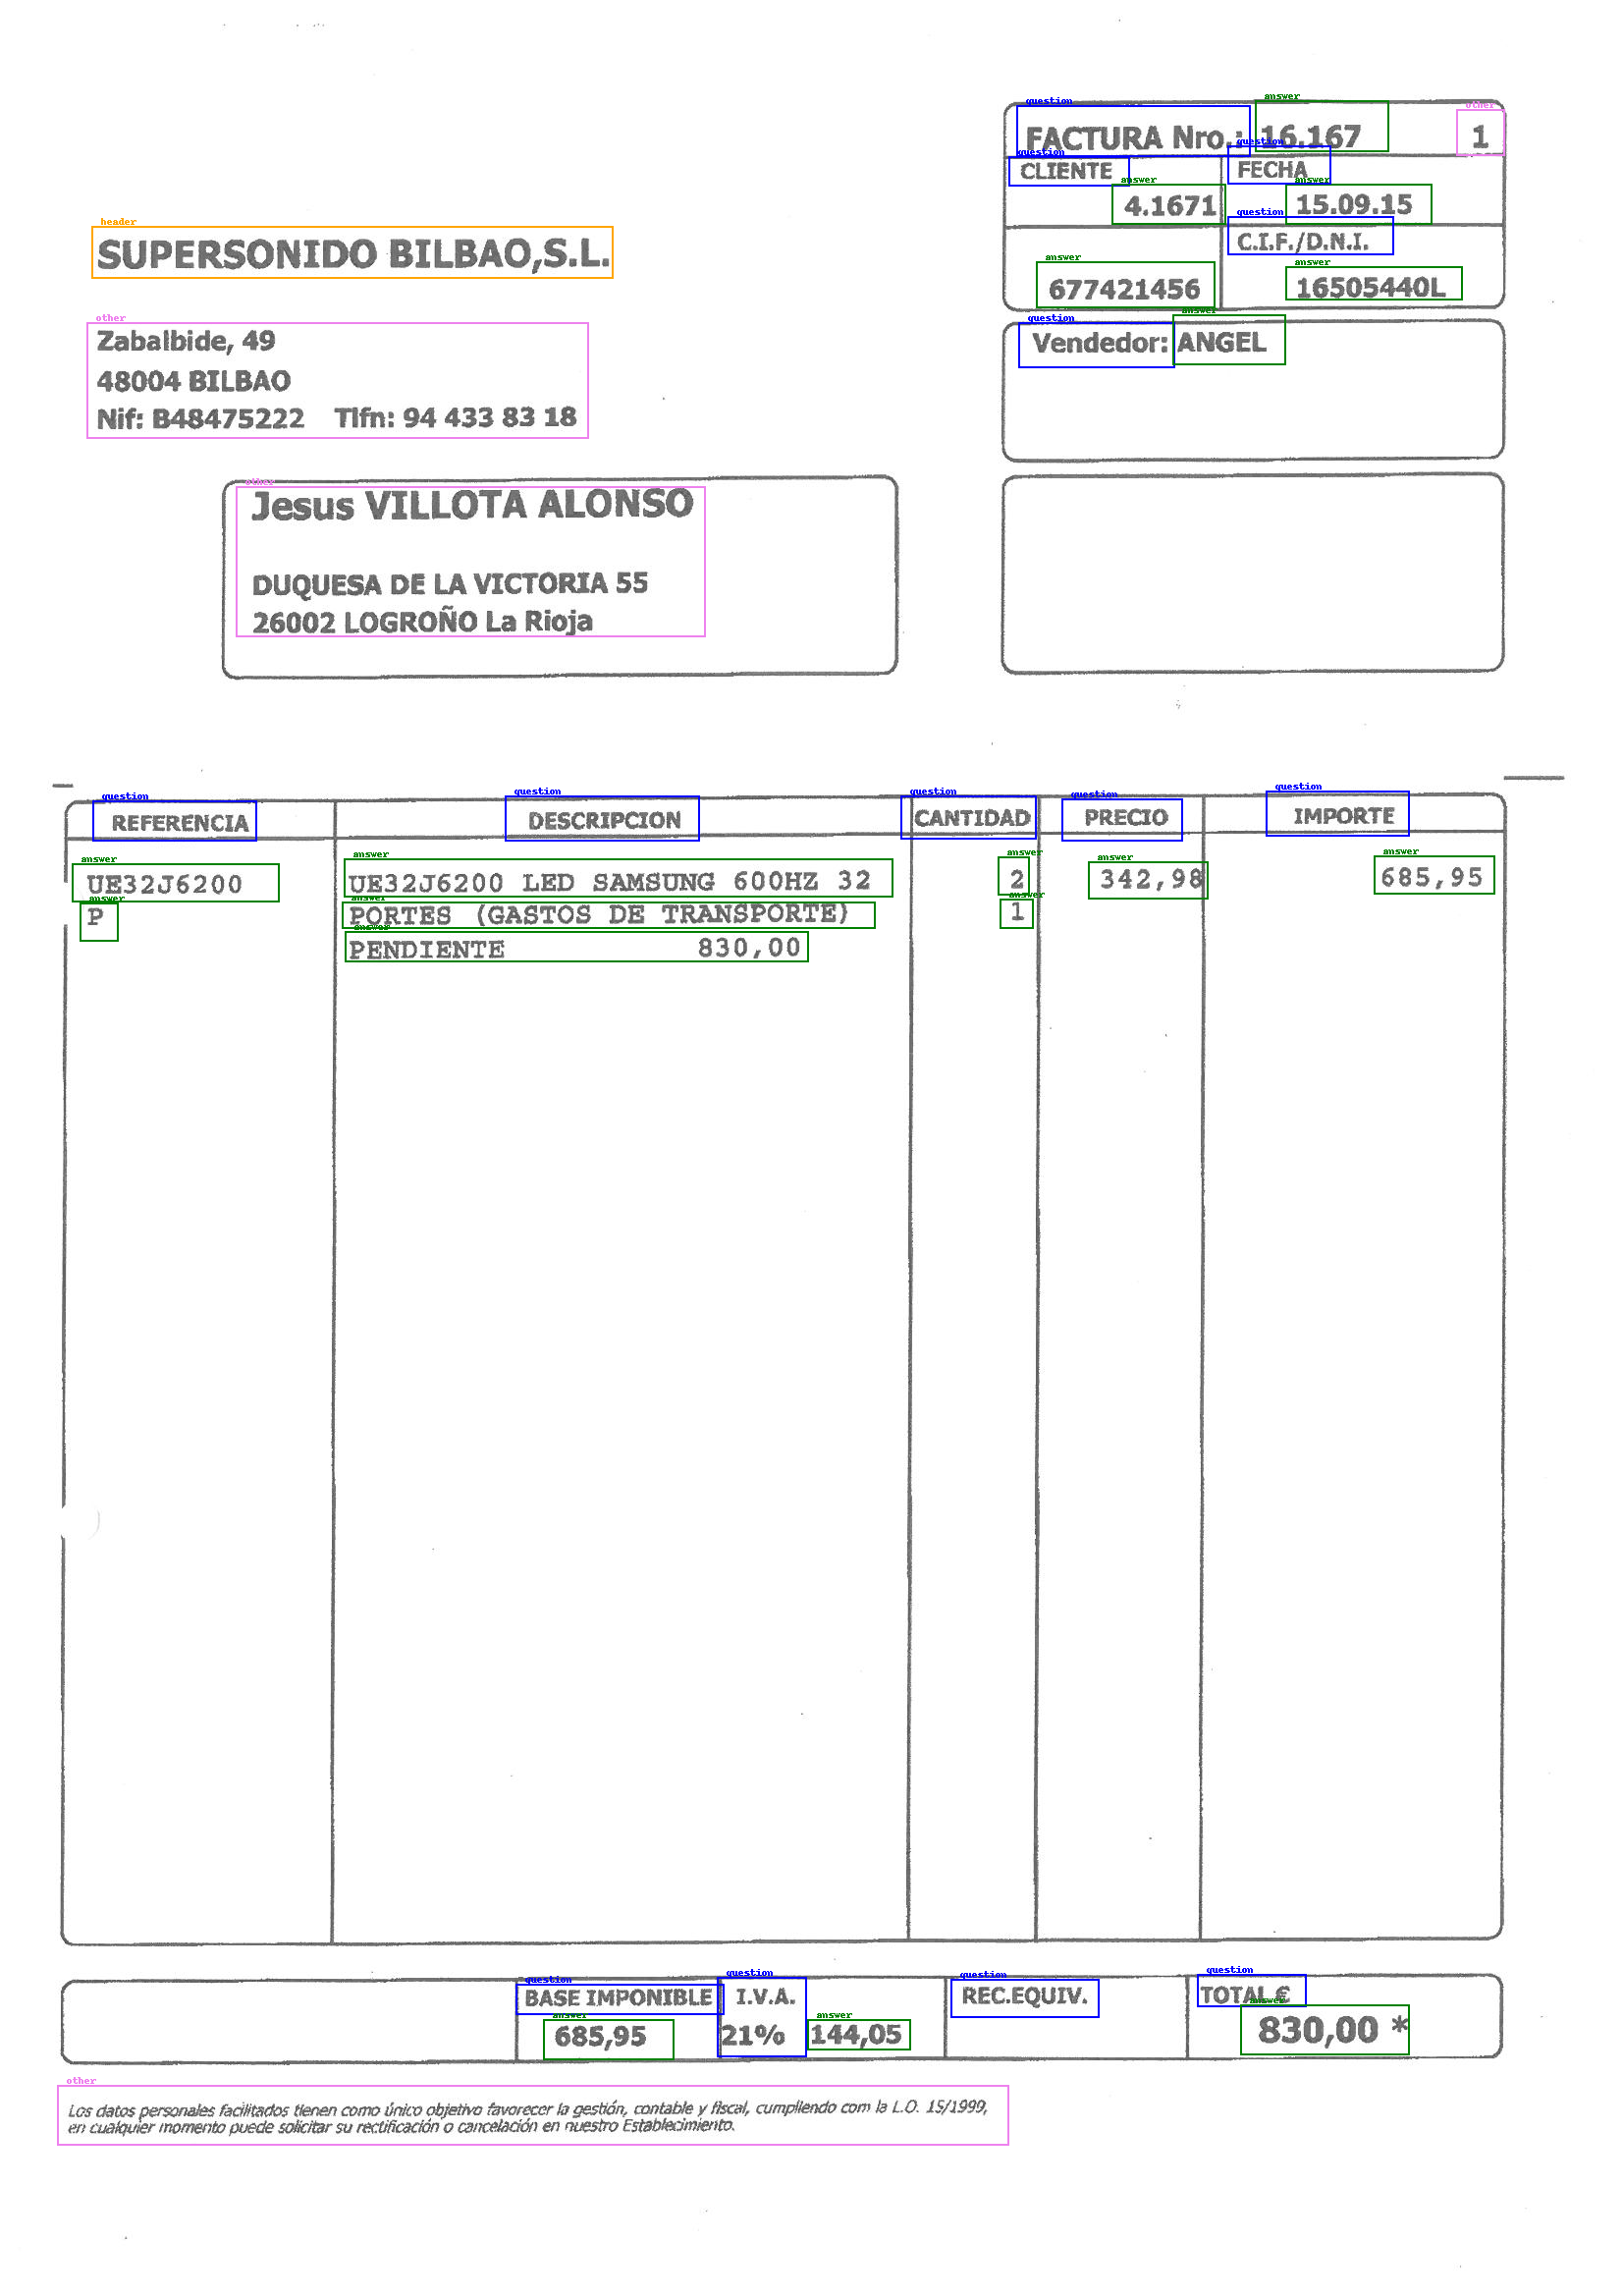

In [41]:
image = Image.open("/content/Facturas/01.jpg")
image = image.convert('RGB')

draw = ImageDraw.Draw(image)

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

path='Facturas'
file="01.xml"
path_file=path+'/'+file
objeto=ET.parse(path_file)
objeto = objeto.getroot()
for bbox in objeto.findall('object'):
  label=bbox.find('name').text
  coords = bbox.find('bndbox')
  general_box = [int(coords.find('xmin').text),int(coords.find('ymin').text),int(coords.find('xmax').text),int(coords.find('ymax').text)]
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)

image

## Results

In [42]:
import numpy as np
import os,shutil,json
import xml.etree.ElementTree as ET
from pathlib import Path

## Ground truth

In [43]:
%mkdir 'input'
%mkdir 'input/ground-truth'
%mkdir 'input/detection-results'

In [44]:
path='Facturas'
for file in [xml for xml in os.listdir(path) if xml[-1]=='l']:
  txt=open('input/ground-truth/'+file[:-4]+'.txt','w')
  path_file=path+'/'+file
  objeto=ET.parse(path_file)
  objeto = objeto.getroot()
  for bbox in objeto.findall('object'):
    label=bbox.find('name').text
    coords = bbox.find('bndbox')
    xmin,ymin,xmax,ymax = coords.find('xmin').text,coords.find('ymin').text,coords.find('xmax').text,coords.find('ymax').text
    txt.write(label + ' ' + xmin + ' ' + ymin + ' '+ xmax + ' '+ ymax +'\n')
  txt.close()
  

## Detections

In [45]:
files=['Facturas/'+xml for xml in os.listdir(path) if xml[-1]=='g']

In [46]:
for f in files:
  image = Image.open(f)
  image = image.convert("RGB")
  f=Path(f)
  txt=open('input/detection-results/'+f.stem+'.txt','w')
  width, height = image.size
  w_scale = 1000/width
  h_scale = 1000/height

  ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \
              
  ocr_df = ocr_df.dropna() \
                .assign(left_scaled = ocr_df.left*w_scale,
                        width_scaled = ocr_df.width*w_scale,
                        top_scaled = ocr_df.top*h_scale,
                        height_scaled = ocr_df.height*h_scale,
                        right_scaled = lambda x: x.left_scaled + x.width_scaled,
                        bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

  float_cols = ocr_df.select_dtypes('float').columns
  ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
  ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
  ocr_df = ocr_df.dropna().reset_index(drop=True)
  words = list(ocr_df.text)
  coordinates = ocr_df[['left', 'top', 'width', 'height']]
  actual_boxes = []
  for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
    actual_boxes.append(actual_box)
  boxes = []
  for box in actual_boxes:
    print(box)
    boxes.append(normalize_box(box, width, height))
  
  input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)
  input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
  attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
  token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
  bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
  outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
  token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

  word_level_predictions = [] # let's turn them into word level predictions
  final_boxes = []
  for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
    if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                            tokenizer.sep_token_id, 
                                                            tokenizer.pad_token_id]):
      # skip prediction + bounding box

      continue
    else:
      word_level_predictions.append(token_pred)
      final_boxes.append(box)
  for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    txt.write(predicted_label+' '+'85'+' '+ str(box[0])+' '+ str(box[1])+' '+ str(box[2])+' '+ str(box[3])+'\n')
  txt.close()

Se han truncado las últimas 5000 líneas del flujo de salida.
[665, 2174, 721, 2188]
[726, 2174, 733, 2186]
[796, 2174, 849, 2186]
[855, 2174, 869, 2186]
[873, 2174, 939, 2190]
[945, 2175, 960, 2186]
[966, 2182, 970, 2183]
[975, 2175, 993, 2186]
[997, 2175, 1029, 2190]
[1041, 2175, 1056, 2187]
[1089, 2175, 1104, 2187]
[1108, 2175, 1159, 2188]
[1164, 2176, 1173, 2187]
[1182, 2176, 1223, 2190]
[1228, 2176, 1244, 2188]
[1249, 2183, 1253, 2184]
[1261, 2176, 1271, 2188]
[1333, 2176, 1352, 2188]
[1353, 2176, 1395, 2188]
[1401, 2176, 1463, 2191]
[1468, 2176, 1482, 2188]
[1487, 2176, 1531, 2188]
[104, 2191, 133, 2203]
[139, 2191, 162, 2203]
[168, 2191, 192, 2203]
[198, 2191, 221, 2203]
[270, 2191, 305, 2203]
[311, 2192, 334, 2203]
[340, 2192, 363, 2204]
[369, 2192, 392, 2204]
[398, 2192, 402, 2203]
[407, 2192, 430, 2204]
[476, 2192, 496, 2204]
[507, 2192, 530, 2204]
[536, 2192, 559, 2204]
[565, 2193, 588, 2204]
[619, 2192, 653, 2204]
[659, 2193, 683, 2204]
[689, 2192, 712, 2204]
[718, 2193, 742

#### Código mAP

In [47]:
import glob
import shutil
import operator
import sys
import argparse
import math
from matplotlib import pyplot as plt
import cv2
import json
import os
import re
from pathlib import Path
from imutils.contours import sort_contours
import numpy as np
import imutils
import sys
import statistics as stats
import pandas as pd
import torch
from sklearn.model_selection import train_test_split


In [48]:
MINOVERLAP = 0.5 # default value (defined in the PASCAL VOC2012 challenge)

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument('-na', '--no-animation', help="no animation is shown.", action="store_true")
parser.add_argument('-np', '--no-plot', help="no plot is shown.", action="store_true")
parser.add_argument('-q', '--quiet', help="minimalistic console output.", action="store_true")
# argparse receiving list of classes to be ignored (e.g., python main.py --ignore person book)
parser.add_argument('-i', '--ignore', nargs='+', type=str, help="ignore a list of classes.")
# # argparse receiving list of classes with specific IoU (e.g., python main.py --set-class-iou person 0.7)
parser.add_argument('--set-class-iou', nargs='+', type=str, help="set IoU for a specific class.")

args = parser.parse_args()

In [49]:
def log_average_miss_rate(prec, rec, num_images):
    """
        log-average miss rate:
            Calculated by averaging miss rates at 9 evenly spaced FPPI points
            between 10e-2 and 10e0, in log-space.
        output:
                lamr | log-average miss rate
                mr | miss rate
                fppi | false positives per image
        references:
            [1] Dollar, Piotr, et al. "Pedestrian Detection: An Evaluation of the
               State of the Art." Pattern Analysis and Machine Intelligence, IEEE
               Transactions on 34.4 (2012): 743 - 761.
    """

    # if there were no detections of that class
    if prec.size == 0:
        lamr = 0
        mr = 1
        fppi = 0
        return lamr, mr, fppi

    fppi = (1 - prec)
    mr = (1 - rec)

    fppi_tmp = np.insert(fppi, 0, -1.0)
    mr_tmp = np.insert(mr, 0, 1.0)

    # Use 9 evenly spaced reference points in log-space
    ref = np.logspace(-2.0, 0.0, num = 9)
    for i, ref_i in enumerate(ref):
        # np.where() will always find at least 1 index, since min(ref) = 0.01 and min(fppi_tmp) = -1.0
        j = np.where(fppi_tmp <= ref_i)[-1][-1]
        ref[i] = mr_tmp[j]

    # log(0) is undefined, so we use the np.maximum(1e-10, ref)
    lamr = math.exp(np.mean(np.log(np.maximum(1e-10, ref))))

    return lamr, mr, fppi

"""
 throw error and exit
"""
def error(msg):
    print(msg)
    sys.exit(0)

"""
 check if the number is a float between 0.0 and 1.0
"""
def is_float_between_0_and_1(value):
    try:
        val = float(value)
        if val > 0.0 and val < 1.0:
            return True
        else:
            return False
    except ValueError:
        return False

"""
 Calculate the AP given the recall and precision array
    1st) We compute a version of the measured precision/recall curve with
         precision monotonically decreasing
    2nd) We compute the AP as the area under this curve by numerical integration.
"""
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


"""
 Convert the lines of a file to a list
"""
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

"""
 Draws text in image
"""
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
            bottomLeftCornerOfText,
            font,
            fontScale,
            color,
            lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)

"""
 Plot - adjust axes
"""
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])

"""
 Draw plot using Matplotlib
"""
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
    # sort the dictionary by decreasing value, into a list of tuples
    sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
    # unpacking the list of tuples into two lists
    sorted_keys, sorted_values = zip(*sorted_dic_by_value)
    # 
    if true_p_bar != "":
        """
         Special case to draw in:
            - green -> TP: True Positives (object detected and matches ground-truth)
            - red -> FP: False Positives (object detected but does not match ground-truth)
            - pink -> FN: False Negatives (object not detected but present in the ground-truth)
        """
        fp_sorted = []
        tp_sorted = []
        for key in sorted_keys:
            fp_sorted.append(dictionary[key] - true_p_bar[key])
            tp_sorted.append(true_p_bar[key])
        plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Positive')
        plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Positive', left=fp_sorted)
        # add legend
        plt.legend(loc='lower right')
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            fp_val = fp_sorted[i]
            tp_val = tp_sorted[i]
            fp_str_val = " " + str(fp_val)
            tp_str_val = fp_str_val + " " + str(tp_val)
            # trick to paint multicolor with offset:
            # first paint everything and then repaint the first number
            t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
            plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    else:
        plt.barh(range(n_classes), sorted_values, color=plot_color)
        """
         Write number on side of bar
        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            str_val = " " + str(val) # add a space before
            if val < 1.0:
                str_val = " {0:.2f}".format(val)
            t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
            # re-set axes to show number inside the figure
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    # set window title
    fig.canvas.set_window_title(window_title)
    # write classes in y axis
    tick_font_size = 12
    plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
    """
     Re-scale height accordingly
    """
    init_height = fig.get_figheight()
    # comput the matrix height in points and inches
    dpi = fig.dpi
    height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
    height_in = height_pt / dpi
    # compute the required figure height 
    top_margin = 0.15 # in percentage of the figure height
    bottom_margin = 0.05 # in percentage of the figure height
    figure_height = height_in / (1 - top_margin - bottom_margin)
    # set new height
    if figure_height > init_height:
        fig.set_figheight(figure_height)

    # set plot title
    plt.title(plot_title, fontsize=14)
    # set axis titles
    # plt.xlabel('classes')
    plt.xlabel(x_label, fontsize='large')
    # adjust size of window
    fig.tight_layout()
    # save the plot
    fig.savefig(output_path)
    # show image
    if to_show:
        plt.show()
    # close the plot
    plt.close()

In [50]:
def mAP():
  # if there are no classes to ignore then replace None by empty list
  if args.ignore is None:
      args.ignore = []

  specific_iou_flagged = False
  if args.set_class_iou is not None:
      specific_iou_flagged = True

  # make sure that the cwd() is the location of the python script (so that every path makes sense)
  #os.chdir(os.path.dirname(os.path.abspath(__file__)))

  GT_PATH = os.path.join(os.getcwd(), 'input', 'ground-truth')
  DR_PATH = os.path.join(os.getcwd(), 'input', 'detection-results')
  # if there are no images then no animation can be shown
  IMG_PATH = os.path.join(os.getcwd(), 'input', 'images-optional')
  if os.path.exists(IMG_PATH): 
      for dirpath, dirnames, files in os.walk(IMG_PATH):
          if not files:
              # no image files found
              args.no_animation = True
  else:
      args.no_animation = True

  # try to import OpenCV if the user didn't choose the option --no-animation
  show_animation = False
  if not args.no_animation:
      try:
          import cv2
          show_animation = True
      except ImportError:
          print("\"opencv-python\" not found, please install to visualize the results.")
          args.no_animation = True

  # try to import Matplotlib if the user didn't choose the option --no-plot
  draw_plot = False
  if not args.no_plot:
      try:
          import matplotlib.pyplot as plt
          draw_plot = True
      except ImportError:
          print("\"matplotlib\" not found, please install it to get the resulting plots.")
          args.no_plot = True



  """
  Create a ".temp_files/" and "output/" directory
  """
  TEMP_FILES_PATH = ".temp_files"
  if not os.path.exists(TEMP_FILES_PATH): # if it doesn't exist already
      os.makedirs(TEMP_FILES_PATH)
  output_files_path = "output"
  if os.path.exists(output_files_path): # if it exist already
      # reset the output directory
      shutil.rmtree(output_files_path)

  os.makedirs(output_files_path)
  if draw_plot:
      os.makedirs(os.path.join(output_files_path, "classes"))
  if show_animation:
      os.makedirs(os.path.join(output_files_path, "images", "detections_one_by_one"))

  """
  ground-truth
      Load each of the ground-truth files into a temporary ".json" file.
      Create a list of all the class names present in the ground-truth (gt_classes).
  """
  # get a list with the ground-truth files
  ground_truth_files_list = glob.glob(GT_PATH + '/*.txt')
  if len(ground_truth_files_list) == 0:
      error("Error: No ground-truth files found!")
  ground_truth_files_list.sort()
  # dictionary with counter per class
  gt_counter_per_class = {}
  counter_images_per_class = {}

  gt_files = []
  for txt_file in ground_truth_files_list:
      #print(txt_file)
      file_id = txt_file.split(".txt", 1)[0]
      file_id = os.path.basename(os.path.normpath(file_id))
      # check if there is a correspondent detection-results file
      temp_path = os.path.join(DR_PATH, (file_id + ".txt"))
      if not os.path.exists(temp_path):
          error_msg = "Error. File not found: {}\n".format(temp_path)
          error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
          error(error_msg)
      lines_list = file_lines_to_list(txt_file)
      # create ground-truth dictionary
      bounding_boxes = []
      is_difficult = False
      already_seen_classes = []
      for line in lines_list:
          try:
              if "difficult" in line:
                      class_name, left, top, right, bottom, _difficult = line.split()
                      is_difficult = True
              else:
                      class_name, left, top, right, bottom = line.split()
          except ValueError:
              error_msg = "Error: File " + txt_file + " in the wrong format.\n"
              error_msg += " Expected: <class_name> <left> <top> <right> <bottom> ['difficult']\n"
              error_msg += " Received: " + line
              error_msg += "\n\nIf you have a <class_name> with spaces between words you should remove them\n"
              error_msg += "by running the script \"remove_space.py\" or \"rename_class.py\" in the \"extra/\" folder."
              error(error_msg)
          # check if class is in the ignore list, if yes skip
          if class_name in args.ignore:
              continue
          bbox = left + " " + top + " " + right + " " +bottom
          if is_difficult:
              bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "difficult":True})
              is_difficult = False
          else:
              bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False})
              # count that object
              if class_name in gt_counter_per_class:
                  gt_counter_per_class[class_name] += 1
              else:
                  # if class didn't exist yet
                  gt_counter_per_class[class_name] = 1

              if class_name not in already_seen_classes:
                  if class_name in counter_images_per_class:
                      counter_images_per_class[class_name] += 1
                  else:
                      # if class didn't exist yet
                      counter_images_per_class[class_name] = 1
                  already_seen_classes.append(class_name)


      # dump bounding_boxes into a ".json" file
      new_temp_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
      gt_files.append(new_temp_file)
      with open(new_temp_file, 'w') as outfile:
          json.dump(bounding_boxes, outfile)

  gt_classes = list(gt_counter_per_class.keys())
  # let's sort the classes alphabetically
  gt_classes = sorted(gt_classes)
  n_classes = len(gt_classes)
  #print(gt_classes)
  #print(gt_counter_per_class)

  """
  Check format of the flag --set-class-iou (if used)
      e.g. check if class exists
  """
  if specific_iou_flagged:
      n_args = len(args.set_class_iou)
      error_msg = \
          '\n --set-class-iou [class_1] [IoU_1] [class_2] [IoU_2] [...]'
      if n_args % 2 != 0:
          error('Error, missing arguments. Flag usage:' + error_msg)
      # [class_1] [IoU_1] [class_2] [IoU_2]
      # specific_iou_classes = ['class_1', 'class_2']
      specific_iou_classes = args.set_class_iou[::2] # even
      # iou_list = ['IoU_1', 'IoU_2']
      iou_list = args.set_class_iou[1::2] # odd
      if len(specific_iou_classes) != len(iou_list):
          error('Error, missing arguments. Flag usage:' + error_msg)
      for tmp_class in specific_iou_classes:
          if tmp_class not in gt_classes:
                      error('Error, unknown class \"' + tmp_class + '\". Flag usage:' + error_msg)
      for num in iou_list:
          if not is_float_between_0_and_1(num):
              error('Error, IoU must be between 0.0 and 1.0. Flag usage:' + error_msg)

  """
  detection-results
      Load each of the detection-results files into a temporary ".json" file.
  """
  # get a list with the detection-results files
  dr_files_list = glob.glob(DR_PATH + '/*.txt')
  dr_files_list.sort()

  for class_index, class_name in enumerate(gt_classes):
      bounding_boxes = []
      for txt_file in dr_files_list:
          #print(txt_file)
          # the first time it checks if all the corresponding ground-truth files exist
          file_id = txt_file.split(".txt",1)[0]
          file_id = os.path.basename(os.path.normpath(file_id))
          temp_path = os.path.join(GT_PATH, (file_id + ".txt"))
          if class_index == 0:
              if not os.path.exists(temp_path):
                  error_msg = "Error. File not found: {}\n".format(temp_path)
                  error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
                  error(error_msg)
          lines = file_lines_to_list(txt_file)
          for line in lines:
              try:
                  tmp_class_name, confidence, left, top, right, bottom = line.split()
              except ValueError:
                  error_msg = "Error: File " + txt_file + " in the wrong format.\n"
                  error_msg += " Expected: <class_name> <confidence> <left> <top> <right> <bottom>\n"
                  error_msg += " Received: " + line
                  error(error_msg)
              if tmp_class_name == class_name:
                  #print("match")
                  bbox = left + " " + top + " " + right + " " +bottom
                  bounding_boxes.append({"confidence":confidence, "file_id":file_id, "bbox":bbox})
                  #print(bounding_boxes)
      # sort detection-results by decreasing confidence
      bounding_boxes.sort(key=lambda x:float(x['confidence']), reverse=True)
      with open(TEMP_FILES_PATH + "/" + class_name + "_dr.json", 'w') as outfile:
          json.dump(bounding_boxes, outfile)

  """
  Calculate the AP for each class
  """
  sum_AP = 0.0
  ap_dictionary = {}
  lamr_dictionary = {}
  # open file to store the output
  with open(output_files_path + "/output.txt", 'w') as output_file:
      output_file.write("# AP and precision/recall per class\n")
      count_true_positives = {}
      for class_index, class_name in enumerate(gt_classes):
          count_true_positives[class_name] = 0
          """
          Load detection-results of that class
          """
          dr_file = TEMP_FILES_PATH + "/" + class_name + "_dr.json"
          dr_data = json.load(open(dr_file))

          """
          Assign detection-results to ground-truth objects
          """
          nd = len(dr_data)
          tp = [0] * nd # creates an array of zeros of size nd
          fp = [0] * nd
          for idx, detection in enumerate(dr_data):
              file_id = detection["file_id"]
              if show_animation:
                  # find ground truth image
                  ground_truth_img = glob.glob1(IMG_PATH, file_id + ".*")
                  #tifCounter = len(glob.glob1(myPath,"*.tif"))
                  if len(ground_truth_img) == 0:
                      error("Error. Image not found with id: " + file_id)
                  elif len(ground_truth_img) > 1:
                      error("Error. Multiple image with id: " + file_id)
                  else: # found image
                      #print(IMG_PATH + "/" + ground_truth_img[0])
                      # Load image
                      img = cv2.imread(IMG_PATH + "/" + ground_truth_img[0])
                      # load image with draws of multiple detections
                      img_cumulative_path = output_files_path + "/images/" + ground_truth_img[0]
                      if os.path.isfile(img_cumulative_path):
                          img_cumulative = cv2.imread(img_cumulative_path)
                      else:
                          img_cumulative = img.copy()
                      # Add bottom border to image
                      bottom_border = 60
                      BLACK = [0, 0, 0]
                      img = cv2.copyMakeBorder(img, 0, bottom_border, 0, 0, cv2.BORDER_CONSTANT, value=BLACK)
              # assign detection-results to ground truth object if any
              # open ground-truth with that file_id
              gt_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
              ground_truth_data = json.load(open(gt_file))
              ovmax = -1
              gt_match = -1
              # load detected object bounding-box
              bb = [ float(x) for x in detection["bbox"].split() ]
              for obj in ground_truth_data:
                  # look for a class_name match
                  if obj["class_name"] == class_name:
                      bbgt = [ float(x) for x in obj["bbox"].split() ]
                      bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
                      iw = bi[2] - bi[0] + 1
                      ih = bi[3] - bi[1] + 1
                      if iw > 0 and ih > 0:
                          # compute overlap (IoU) = area of intersection / area of union
                          ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                                          + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                          ov = iw * ih / ua
                          if ov > ovmax:
                              ovmax = ov
                              gt_match = obj

              # assign detection as true positive/don't care/false positive
              if show_animation:
                  status = "NO MATCH FOUND!" # status is only used in the animation
              # set minimum overlap
              min_overlap = MINOVERLAP
              if specific_iou_flagged:
                  if class_name in specific_iou_classes:
                      index = specific_iou_classes.index(class_name)
                      min_overlap = float(iou_list[index])
              if ovmax >= min_overlap:
                  if "difficult" not in gt_match:
                          if not bool(gt_match["used"]):
                              # true positive
                              tp[idx] = 1
                              gt_match["used"] = True
                              count_true_positives[class_name] += 1
                              # update the ".json" file
                              with open(gt_file, 'w') as f:
                                      f.write(json.dumps(ground_truth_data))
                              if show_animation:
                                  status = "MATCH!"
                          else:
                              # false positive (multiple detection)
                              fp[idx] = 1
                              if show_animation:
                                  status = "REPEATED MATCH!"
              else:
                  # false positive
                  fp[idx] = 1
                  if ovmax > 0:
                      status = "INSUFFICIENT OVERLAP"

              """
              Draw image to show animation
              """
              if show_animation:
                  height, widht = img.shape[:2]
                  # colors (OpenCV works with BGR)
                  white = (255,255,255)
                  light_blue = (255,200,100)
                  green = (0,255,0)
                  light_red = (30,30,255)
                  # 1st line
                  margin = 10
                  v_pos = int(height - margin - (bottom_border / 2.0))
                  text = "Image: " + ground_truth_img[0] + " "
                  img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                  text = "Class [" + str(class_index) + "/" + str(n_classes) + "]: " + class_name + " "
                  img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), light_blue, line_width)
                  if ovmax != -1:
                      color = light_red
                      if status == "INSUFFICIENT OVERLAP":
                          text = "IoU: {0:.2f}% ".format(ovmax*100) + "< {0:.2f}% ".format(min_overlap*100)
                      else:
                          text = "IoU: {0:.2f}% ".format(ovmax*100) + ">= {0:.2f}% ".format(min_overlap*100)
                          color = green
                      img, _ = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)
                  # 2nd line
                  v_pos += int(bottom_border / 2.0)
                  rank_pos = str(idx+1) # rank position (idx starts at 0)
                  text = "Detection #rank: " + rank_pos + " confidence: {0:.2f}% ".format(float(detection["confidence"])*100)
                  img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                  color = light_red
                  if status == "MATCH!":
                      color = green
                  text = "Result: " + status + " "
                  img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)

                  font = cv2.FONT_HERSHEY_SIMPLEX
                  if ovmax > 0: # if there is intersections between the bounding-boxes
                      bbgt = [ int(round(float(x))) for x in gt_match["bbox"].split() ]
                      cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                      cv2.rectangle(img_cumulative,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                      cv2.putText(img_cumulative, class_name, (bbgt[0],bbgt[1] - 5), font, 0.6, light_blue, 1, cv2.LINE_AA)
                  bb = [int(i) for i in bb]
                  cv2.rectangle(img,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                  cv2.rectangle(img_cumulative,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                  cv2.putText(img_cumulative, class_name, (bb[0],bb[1] - 5), font, 0.6, color, 1, cv2.LINE_AA)
                  # show image
                  cv2.imshow("Animation", img)
                  cv2.waitKey(20) # show for 20 ms
                  # save image to output
                  output_img_path = output_files_path + "/images/detections_one_by_one/" + class_name + "_detection" + str(idx) + ".jpg"
                  cv2.imwrite(output_img_path, img)
                  # save the image with all the objects drawn to it
                  cv2.imwrite(img_cumulative_path, img_cumulative)

          #print(tp)
          # compute precision/recall
          cumsum = 0
          for idx, val in enumerate(fp):
              fp[idx] += cumsum
              cumsum += val
          cumsum = 0
          for idx, val in enumerate(tp):
              tp[idx] += cumsum
              cumsum += val
          #print(tp)
          rec = tp[:]
          for idx, val in enumerate(tp):
              rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
          #print(rec)
          prec = tp[:]
          for idx, val in enumerate(tp):
              prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])
          #print(prec)

          ap, mrec, mprec = voc_ap(rec[:], prec[:])
          sum_AP += ap
          text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)
          """
          Write to output.txt
          """
          rounded_prec = [ '%.2f' % elem for elem in prec ]
          rounded_rec = [ '%.2f' % elem for elem in rec ]
          output_file.write(text + "\n Precision: " + str(rounded_prec) + "\n Recall :" + str(rounded_rec) + "\n\n")
          if not args.quiet:
              print(text)
          ap_dictionary[class_name] = ap

          n_images = counter_images_per_class[class_name]
          lamr, mr, fppi = log_average_miss_rate(np.array(prec), np.array(rec), n_images)
          lamr_dictionary[class_name] = lamr

          """
          Draw plot
          """
          if draw_plot:
              plt.plot(rec, prec, '-o')
              # add a new penultimate point to the list (mrec[-2], 0.0)
              # since the last line segment (and respective area) do not affect the AP value
              area_under_curve_x = mrec[:-1] + [mrec[-2]] + [mrec[-1]]
              area_under_curve_y = mprec[:-1] + [0.0] + [mprec[-1]]
              plt.fill_between(area_under_curve_x, 0, area_under_curve_y, alpha=0.2, edgecolor='r')
              # set window title
              fig = plt.gcf() # gcf - get current figure
              fig.canvas.set_window_title('AP ' + class_name)
              # set plot title
              plt.title('class: ' + text)
              #plt.suptitle('This is a somewhat long figure title', fontsize=16)
              # set axis titles
              plt.xlabel('Recall')
              plt.ylabel('Precision')
              # optional - set axes
              axes = plt.gca() # gca - get current axes
              axes.set_xlim([0.0,1.0])
              axes.set_ylim([0.0,1.05]) # .05 to give some extra space
              # Alternative option -> wait for button to be pressed
              #while not plt.waitforbuttonpress(): pass # wait for key display
              # Alternative option -> normal display
              #plt.show()
              # save the plot
              fig.savefig(output_files_path + "/classes/" + class_name + ".png")
              plt.cla() # clear axes for next plot

      if show_animation:
          cv2.destroyAllWindows()

      output_file.write("\n# mAP of all classes\n")
      mAP = sum_AP / n_classes
      text = "mAP = {0:.2f}%".format(mAP*100)
      output_file.write(text + "\n")
      print(text)

  """
  Draw false negatives
  """
  if show_animation:
      pink = (203,192,255)
      for tmp_file in gt_files:
          ground_truth_data = json.load(open(tmp_file))
          #print(ground_truth_data)
          # get name of corresponding image
          start = TEMP_FILES_PATH + '/'
          img_id = tmp_file[tmp_file.find(start)+len(start):tmp_file.rfind('_ground_truth.json')]
          img_cumulative_path = output_files_path + "/images/" + img_id + ".jpg"
          img = cv2.imread(img_cumulative_path)
          if img is None:
              img_path = IMG_PATH + '/' + img_id + ".jpg"
              img = cv2.imread(img_path)
          # draw false negatives
          for obj in ground_truth_data:
              if not obj['used']:
                  bbgt = [ int(round(float(x))) for x in obj["bbox"].split() ]
                  cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),pink,2)
          cv2.imwrite(img_cumulative_path, img)

  # remove the temp_files directory
  shutil.rmtree(TEMP_FILES_PATH)

  """
  Count total of detection-results
  """
  # iterate through all the files
  det_counter_per_class = {}
  for txt_file in dr_files_list:
      # get lines to list
      lines_list = file_lines_to_list(txt_file)
      for line in lines_list:
          class_name = line.split()[0]
          # check if class is in the ignore list, if yes skip
          if class_name in args.ignore:
              continue
          # count that object
          if class_name in det_counter_per_class:
              det_counter_per_class[class_name] += 1
          else:
              # if class didn't exist yet
              det_counter_per_class[class_name] = 1
  #print(det_counter_per_class)
  dr_classes = list(det_counter_per_class.keys())


  """
  Plot the total number of occurences of each class in the ground-truth
  """
  if draw_plot:
      window_title = "ground-truth-info"
      plot_title = "ground-truth\n"
      plot_title += "(" + str(len(ground_truth_files_list)) + " files and " + str(n_classes) + " classes)"
      x_label = "Number of objects per class"
      output_path = output_files_path + "/ground-truth-info.png"
      to_show = False
      plot_color = 'forestgreen'
      draw_plot_func(
          gt_counter_per_class,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          '',
          )

  """
  Write number of ground-truth objects per class to results.txt
  """
  with open(output_files_path + "/output.txt", 'a') as output_file:
      output_file.write("\n# Number of ground-truth objects per class\n")
      for class_name in sorted(gt_counter_per_class):
          output_file.write(class_name + ": " + str(gt_counter_per_class[class_name]) + "\n")

  """
  Finish counting true positives
  """
  for class_name in dr_classes:
      # if class exists in detection-result but not in ground-truth then there are no true positives in that class
      if class_name not in gt_classes:
          count_true_positives[class_name] = 0
  #print(count_true_positives)

  """
  Plot the total number of occurences of each class in the "detection-results" folder
  """
  if draw_plot:
      window_title = "detection-results-info"
      # Plot title
      plot_title = "detection-results\n"
      plot_title += "(" + str(len(dr_files_list)) + " files and "
      count_non_zero_values_in_dictionary = sum(int(x) > 0 for x in list(det_counter_per_class.values()))
      plot_title += str(count_non_zero_values_in_dictionary) + " detected classes)"
      # end Plot title
      x_label = "Number of objects per class"
      output_path = output_files_path + "/detection-results-info.png"
      to_show = False
      plot_color = 'forestgreen'
      true_p_bar = count_true_positives
      draw_plot_func(
          det_counter_per_class,
          len(det_counter_per_class),
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          true_p_bar
          )

  """
  Write number of detected objects per class to output.txt
  """
  with open(output_files_path + "/output.txt", 'a') as output_file:
      output_file.write("\n# Number of detected objects per class\n")
      for class_name in sorted(dr_classes):
          n_det = det_counter_per_class[class_name]
          text = class_name + ": " + str(n_det)
          text += " (tp:" + str(count_true_positives[class_name]) + ""
          text += ", fp:" + str(n_det - count_true_positives[class_name]) + ")\n"
          output_file.write(text)

  """
  Draw log-average miss rate plot (Show lamr of all classes in decreasing order)
  """
  if draw_plot:
      window_title = "lamr"
      plot_title = "log-average miss rate"
      x_label = "log-average miss rate"
      output_path = output_files_path + "/lamr.png"
      to_show = False
      plot_color = 'royalblue'
      draw_plot_func(
          lamr_dictionary,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          ""
          )

  """
  Draw mAP plot (Show AP's of all classes in decreasing order)
  """
  if draw_plot:
      window_title = "mAP"
      plot_title = "mAP = {0:.2f}%".format(mAP*100)
      x_label = "Average Precision"
      output_path = output_files_path + "/mAP.png"
      to_show = False
      plot_color = 'royalblue'
      draw_plot_func(
          ap_dictionary,
          n_classes,
          window_title,
          plot_title,
          x_label,
          output_path,
          to_show,
          plot_color,
          ""
          )

## Resultados

In [51]:
mAP()

1.28% = answer AP 
0.24% = header AP 
0.02% = other AP 
1.40% = question AP 
mAP = 0.74%


In [52]:
txt=open('/content/output/output.txt','r')
linea=txt.readline()
gt=[]
dt=[]
while linea!= '# Number of ground-truth objects per class\n':
  linea=txt.readline()
gt.append(txt.readline().split()[1]) 
gt.append(txt.readline().split()[1]) 
gt.append(txt.readline().split()[1]) 
gt.append(txt.readline().split()[1])   
txt.readline()
txt.readline()
dt.append(txt.readline().split()[1:])
dt.append(txt.readline().split()[1:])
dt.append(txt.readline().split()[1:])
dt.append(txt.readline().split()[1:])

precision= stats.mean([float(dt[i][1][4:-1])/(float(dt[i][1][4:-1])+float(dt[i][2][3:-1])) for i in range(0,4) if len(dt[i])!=0])
print('precision: ',precision)
recall=stats.mean([float(dt[i][1][4:-1])/float(gt[i])  for i in range(0,4)if len(dt[i])!=0])
print('recall: ',recall)
print('f1-score: ',2*precision*recall/(precision+recall))

precision:  0.032026310122785784
recall:  0.11774185351447868
f1-score:  0.05035565668307455


In [53]:
def abrirImagen(path):
  return cv2.imread(str(path))
  
def mostrarImagen(image,h=20,w=15):
  if len(image.shape)==3:
    img2 = image[:,:,::-1]
    plt.figure(figsize=(h,w))
    plt.imshow(img2)
    plt.show()
  else:
    img2 = image
    plt.figure(figsize=(h,w))
    plt.imshow(img2,cmap='gray')
    plt.show()

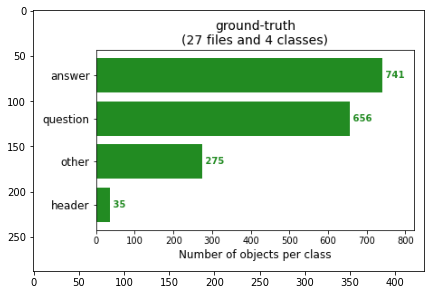

In [54]:
mostrarImagen(abrirImagen('/content/output/ground-truth-info.png'),7,5)

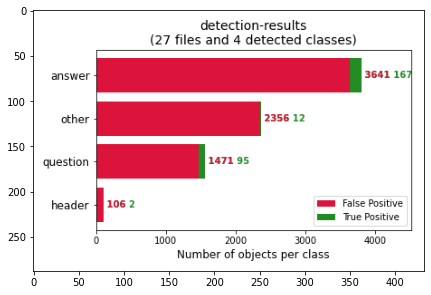

In [55]:
mostrarImagen(abrirImagen('/content/output/detection-results-info.png'),7,5)

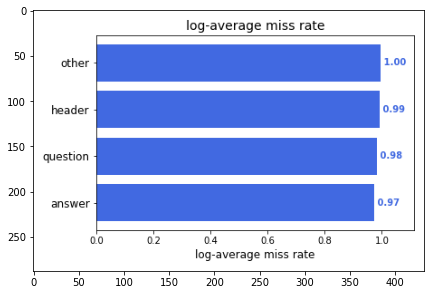

In [56]:
mostrarImagen(abrirImagen('/content/output/lamr.png'),7,5)

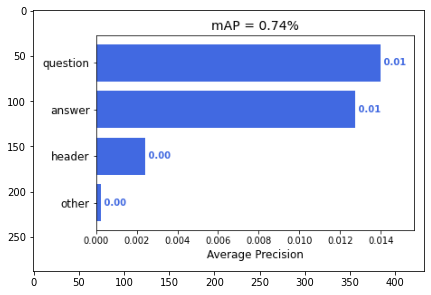

In [57]:
mostrarImagen(abrirImagen('/content/output/mAP.png'),7,5)